In [82]:
import pandas as pd
%matplotlib inline
from aws_helpers import execute_athena_query
import matplotlib.pyplot as plt

results_url = execute_athena_query("select site_id, site_name, lat, lon, avg(temperature) as temperature from weather group by site_id, site_name, lat, lon")
df = pd.read_csv(results_url)

df

Executing: select site_id, site_name, lat, lon, avg(temperature) as temperature from weather group by site_id, site_name, lat, lon
Wait count 0/30
Query succeeded


,site_id,site_name,lat,lon,temperature
0,3132,WEST FREUGH,54.859,-4.936,6.911055
1,3212,KESWICK,54.614,-3.157,5.807538
2,3305,CAPEL CURIG,53.093,-3.941,6.446734
3,3316,CROSBY,53.497,-3.056,7.078392
4,3344,BINGLEY SAMOS,53.811,-1.865,5.603015
...,...,...,...,...,...
132,3649,BRIZE NORTON,51.758,-1.576,9.090500
133,3716,ST-ATHAN,51.405,-3.440,9.094500
134,3743,LARKHILL,51.201,-1.805,8.706533
135,3876,SHOREHAM,50.836,-0.292,9.382500


# Raw Scatter plot

Note that the coordinates will look a bit weird, because the earth is round ;)

<AxesSubplot:xlabel='lon', ylabel='lat'>

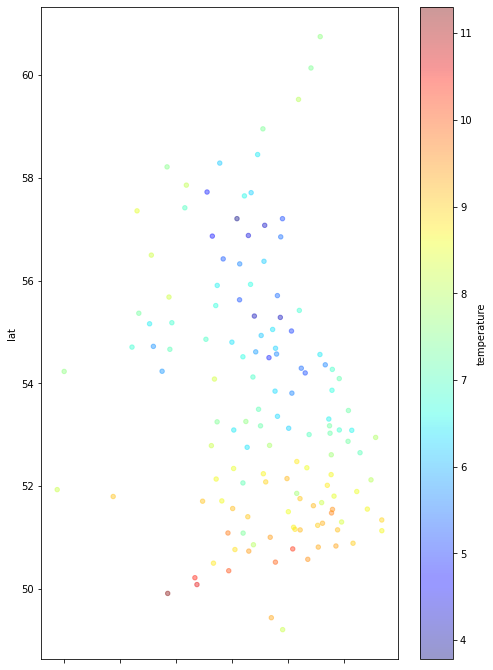

In [83]:
df.plot(
    kind="scatter",
    x="lon", y="lat",
    figsize=(8,12),
    cmap=plt.get_cmap("jet"),
    c='temperature',
    colorbar=True, alpha=0.4
)

# Raw Scatter Plot with OSGB Coords

How to convert coords to OSGB Eastings and Northings

In [84]:
from OSGridConverter import latlong2grid

def convert(r):
    g=latlong2grid(r['lat'], r['lon'])
    r['osgb_E'] = g.E
    r['osgb_N'] = g.N
    return r

osgb = df.apply(convert, axis=1)

osgb

,site_id,site_name,lat,lon,temperature,osgb_E,osgb_N
0,3132,WEST FREUGH,54.859,-4.936,6.911055,211650,555529
1,3212,KESWICK,54.614,-3.157,5.807538,325376,524931
2,3305,CAPEL CURIG,53.093,-3.941,6.446734,270119,356849
3,3316,CROSBY,53.497,-3.056,7.078392,330044,400552
4,3344,BINGLEY SAMOS,53.811,-1.865,5.603015,408987,434976
...,...,...,...,...,...,...,...
132,3649,BRIZE NORTON,51.758,-1.576,9.090500,429362,206675
133,3716,ST-ATHAN,51.405,-3.440,9.094500,299933,168314
134,3743,LARKHILL,51.201,-1.805,8.706533,413720,144661
135,3876,SHOREHAM,50.836,-0.292,9.382500,520367,105442


# Folium

Another python library that wraps Leaflet.  Unlike ipyleaflet, it actually works.  However, because the output is a big chunk of interactive JS, you don't see the output on platforms like github - so what you gain in interactivity, you lose in sharability.

In [109]:
import folium
from branca.element import Figure

fig=Figure(width=600,height=800)

mid_lat = df['lat'].mean()
mid_lon = df['lon'].mean()

m = folium.Map(location=[mid_lat, mid_lon], tiles = 'Stamen Terrain', zoom_start=6)

df['marker_color'] = pd.cut(df['temperature'], bins=4, labels=['#5555DD', '#55DD55', '#FFAA66', '#DD5555'])

for index, row in df.iterrows():
    folium.CircleMarker(location=(row['lat'], row['lon']), radius=4, weight=2, color=row['marker_color'], fill_color=row['marker_color'], fill_opacity=0.7).add_to(m)

fig.add_child(m)
m